# Sensitivities in Finance
**Stefano Ferioli - Gianfranco Arrighetti - Tommaso Fioratti**

Stochastic Simulation - Fall semester 2024-2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# We initialize a random number generator for reproducibility
rng = np.random.default_rng(42)

PLOTS_FOLDER = "plots/"

## European call option
The payoff of a European call option at maturity is defined as
$$f(S_T) = e^{-rT}[S_T - K]^+$$
where $[x]^+ = \max\{x, 0\}$. Here we take
- interest rate $r = 0.05$
- maturity time $T = 1$
- volatility $\sigma = 0.25$
- initial asset price $S_0 = 100$
- strike price $K = 120$

In [2]:
# Define S and f for European call option
def S(WT, r = 0.05, T = 1, sig = 0.25, S0=100):
    return S0 * np.exp((r-0.5*sig**2)*T + sig*WT)
def f(S, r = 0.05, T = 1, K = 120):
    return np.exp(-r*T)*np.maximum(S - K, 0)

# Define functions for analytical values
def d1(S0, K, r, sig, T):
    return (np.log(S0 / K) + (r + 0.5 * sig**2) * T) / (sig * np.sqrt(T))
def d2(S0, K, r, sig, T):
    return d1(S0, K, r, sig, T) - sig * np.sqrt(T)
def delta_analytical(S0, K, r, sig, T):
    s1 = norm.cdf(d1(S0, K, r, sig, T))
    s2 = norm.pdf(d1(S0, K, r, sig, T)) / (sig * np.sqrt(T))
    s3 = - norm.pdf(d2(S0, K, r, sig, T)) * K * np.exp(-r*T) / (sig * np.sqrt(T) * S0)
    return s1 + s2 + s3
def vega_analytical(S0, K, r, sig, T):
    s1 = norm.pdf(d1(S0, K, r, sig, T)) * S0 * (- (np.log(S0 / K) + (r + 0.5 * sig**2) * T) / (sig * sig * np.sqrt(T)) + np.sqrt(T))
    s2 = - norm.pdf(d2(S0, K, r, sig, T)) * K * np.exp(-r*T) * (- (np.log(S0 / K) + (r + 0.5 * sig**2) * T) / (sig * sig * np.sqrt(T)))
    return s1 + s2

def de_norm_pdf(x):
    return - x * np.exp(-0.5 * x * x) / np.sqrt(2 * np.pi)
def gamma_analytical(S0, K, r, sig, T):
    s1 = norm.pdf(d1(S0, K, r, sig, T)) / (sig * np.sqrt(T) * S0)
    s2 = de_norm_pdf(d1(S0, K, r, sig, T)) / (sig * sig * T * S0)
    s3 = - de_norm_pdf(d2(S0, K, r, sig, T)) * K * np.exp(-r*T) / (sig * sig * T * S0 * S0)
    s4 = norm.pdf(d2(S0, K, r, sig, T)) * K * np.exp(-r*T) / (sig * np.sqrt(T) * S0 * S0)
    return s1 + s2 + s3 + s4

# Set parameters
r = 0.05
T = 1
sig = 0.25
S0 = 100
K = 120

num_NN = 100
NN = np.logspace(3,6,num_NN).astype(int)
NN = np.array([x for (i,x) in enumerate(NN) if i==0 or x>NN[i-1]])

h = 0.00001

# Define dictionary to collect the variances
stds = {}

### a) Estimate Delta and Vega

#### Estimate Delta using finite differences

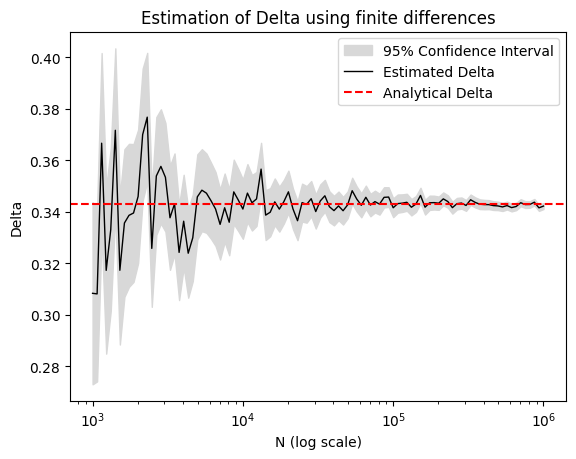

In [3]:
deltas = np.empty(num_NN, dtype=float)
deltas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = (f(S(WT, S0 = S0 + h)) - f(S(WT, S0 = S0 - h)))/(2*h)

    deltas[i] = np.mean(sample)
    deltas_std[i] = np.std(sample)/np.sqrt(N)

stds["delta_fd"] = np.std(sample)


plt.fill_between(
    NN, 
    deltas - 1.96*deltas_std, 
    deltas + 1.96*deltas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    deltas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Delta'
)
plt.axhline(
    y=delta_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Delta")
plt.title("Estimation of Delta using finite differences")

plt.legend()
plt.savefig(PLOTS_FOLDER + "a_delta_finite_diff.pdf", format='pdf', bbox_inches='tight')
plt.show()

#### Estimate Vega using finite differences

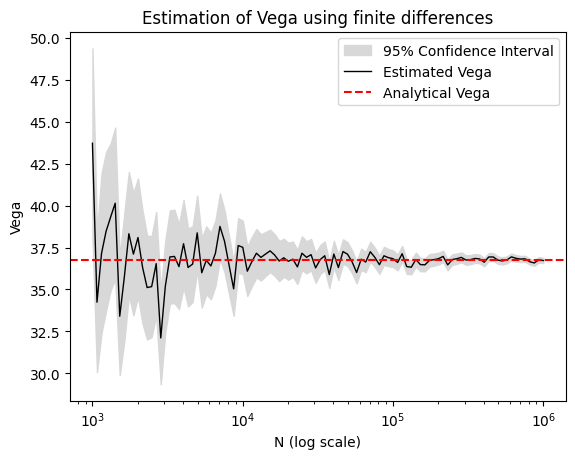

In [4]:
vegas = np.empty(num_NN, dtype=float)
vegas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = (f(S(WT, sig = sig + h)) - f(S(WT, sig = sig - h)))/(2*h)

    vegas[i] = np.mean(sample)
    vegas_std[i] = np.std(sample)/np.sqrt(N)

stds["vega_fd"] = np.std(sample)


plt.fill_between(
    NN, 
    vegas - 1.96*vegas_std, 
    vegas + 1.96*vegas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    vegas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Vega'
)
plt.axhline(
    y=vega_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Vega'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Vega")
plt.title("Estimation of Vega using finite differences")

plt.legend()
plt.savefig(PLOTS_FOLDER + "a_vega_finite_diff.pdf", format='pdf', bbox_inches='tight')
plt.show()

#### Investigate how h impacts the estimate of Delta

In [5]:
# Set parameters
N = 1000000

num_hh = 100
hh = np.logspace(-8,-0.5,num_hh)
hh = np.array([x for (i,x) in enumerate(hh) if i==0 or x>hh[i-1]])

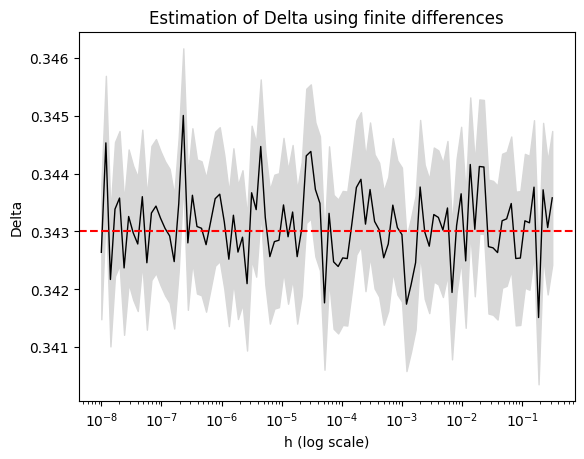

In [6]:
deltas = np.empty(num_hh, dtype=float)
deltas_std = np.empty(num_hh, dtype=float)
for i, h in enumerate(hh):
    WT = rng.normal(0, T, size=N)

    sample = (f(S(WT, S0 = S0 + h)) - f(S(WT, S0 = S0 - h)))/(2*h)

    deltas[i] = np.mean(sample)
    deltas_std[i] = np.std(sample)/np.sqrt(N)


plt.fill_between(
    hh, 
    deltas - 1.96*deltas_std, 
    deltas + 1.96*deltas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    hh, 
    deltas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Delta'
)
plt.axhline(
    y=delta_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("h (log scale)")
plt.ylabel("Delta")
plt.title("Estimation of Delta using finite differences")

plt.savefig(PLOTS_FOLDER + "a_delta_finite_diff_h.pdf", format='pdf', bbox_inches='tight')

#### Investigate how h impacts the estimate of Vega

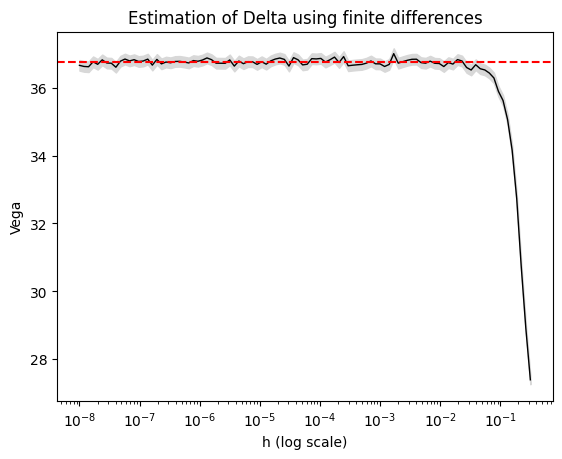

In [7]:
vegas = np.empty(num_hh, dtype=float)
vegas_std = np.empty(num_hh, dtype=float)
for i, h in enumerate(hh):
    WT = rng.normal(0, T, size=N)

    sample = (f(S(WT, sig = sig + h)) - f(S(WT, sig = sig - h)))/(2*h)

    vegas[i] = np.mean(sample)
    vegas_std[i] = np.std(sample)/np.sqrt(N)


plt.fill_between(
    hh, 
    vegas - 1.96*vegas_std, 
    vegas + 1.96*vegas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    hh, 
    vegas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Vega'
)
plt.axhline(
    y=vega_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Vega'
)

plt.xscale('log')

plt.xlabel("h (log scale)")
plt.ylabel("Vega")
plt.title("Estimation of Delta using finite differences")

plt.savefig(PLOTS_FOLDER + "a_vega_finite_diff_h.pdf", format='pdf', bbox_inches='tight')

#### Estimate Delta using pathwise derivative

In [8]:
# Define derivarive of f and derivative of S wrt S0
def de_f(S, r = 0.05, T = 1, K = 120):
    return np.exp(-r*T) * np.array([1. if x-K >= 0 else 0. for x in S])
def de_S0_S(WT, r = 0.05, T = 1, sig = 0.25, S0=100):
    return np.exp((r-0.5*sig**2)*T + sig*WT)

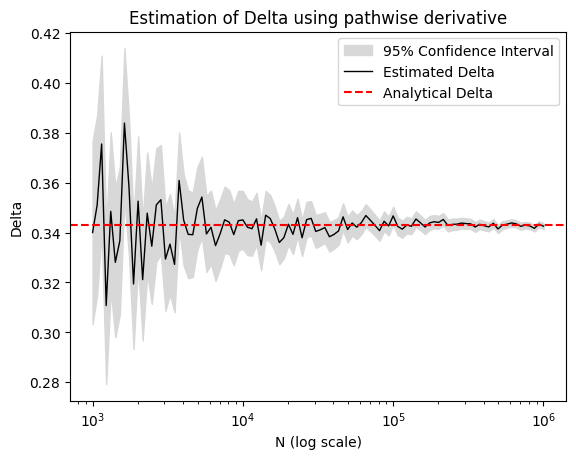

In [9]:
deltas = np.empty(num_NN, dtype=float)
deltas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = de_f(S(WT)) * de_S0_S(WT)
    
    deltas[i] = np.mean(sample)
    deltas_std[i] = np.std(sample)/np.sqrt(N)

stds["delta_pw"] = np.std(sample)


plt.fill_between(
    NN, 
    deltas - 1.96*deltas_std, 
    deltas + 1.96*deltas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    deltas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Delta'
)
plt.axhline(
    y=delta_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Delta")
plt.title("Estimation of Delta using pathwise derivative")

plt.legend()
plt.savefig(PLOTS_FOLDER + "a_delta_path.pdf", format='pdf', bbox_inches='tight')

#### Estimate Vega using pathwise derivative

In [10]:
# Define derivative of S wrt sigma
def de_sig_S(WT, r = 0.05, T = 1, sig = 0.25, S0=100):
    return (-sig * T + WT) * S0 * np.exp((r-0.5*sig**2)*T + sig*WT)

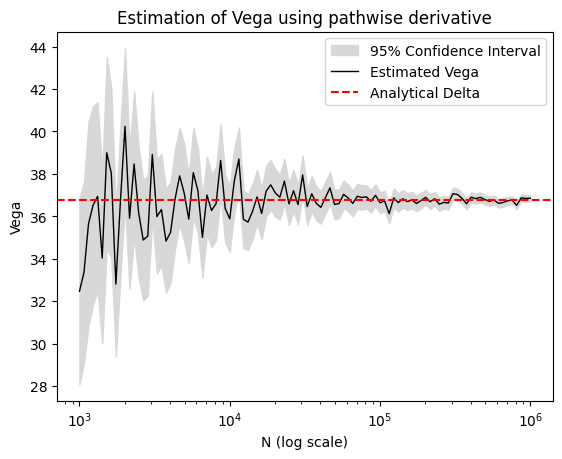

In [11]:
vegas = np.empty(num_NN, dtype=float)
vegas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = de_f(S(WT)) * de_sig_S(WT)
    
    vegas[i] = np.mean(sample)
    vegas_std[i] = np.std(sample)/np.sqrt(N)

stds["vega_pw"] = np.std(sample)


plt.fill_between(
    NN, 
    vegas - 1.96*vegas_std, 
    vegas + 1.96*vegas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    vegas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Vega'
)
plt.axhline(
    y=vega_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Vega")
plt.title("Estimation of Vega using pathwise derivative")

plt.legend()
plt.savefig(PLOTS_FOLDER + "a_vega_path.pdf", format='pdf', bbox_inches='tight')

#### Estimate Delta using likelihood ratio method

In [12]:
# Define derivative of the score function wrt S0
def de_S0_logp(S, r = 0.05, T = 1, sig = 0.25, S0=100):
    return (np.log(S/S0)-(r-0.5*sig**2)*T)/(sig**2*T*S0)

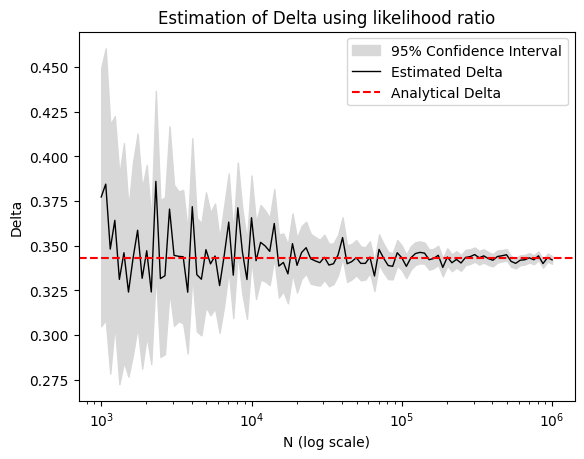

In [13]:
deltas = np.empty(num_NN, dtype=float)
deltas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = f(S(WT)) * de_S0_logp(S(WT))
    
    deltas[i] = np.mean(sample)
    deltas_std[i] = np.std(sample)/np.sqrt(N)

stds["delta_lr"] = np.std(sample)

plt.fill_between(
    NN, 
    deltas - 1.96*deltas_std, 
    deltas + 1.96*deltas_std,
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    deltas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Delta'
)
plt.axhline(
    y=delta_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Delta")
plt.title("Estimation of Delta using likelihood ratio")

plt.legend()
plt.savefig(PLOTS_FOLDER + "a_delta_like_ratio.pdf", format='pdf', bbox_inches='tight')

#### Estimate Vega using likelihood ratio method

In [14]:
# Define derivative of the score function wrt sigma
def de_sig_logp(S, r = 0.05, T = 1, sig = 0.25, S0=100):
    s1 = (np.log(S/S0) - (r - 0.5 * sig**2) * T) / (sig * np.sqrt(T))
    return - 1./sig - s1 * (np.sqrt(T) - s1 / sig)

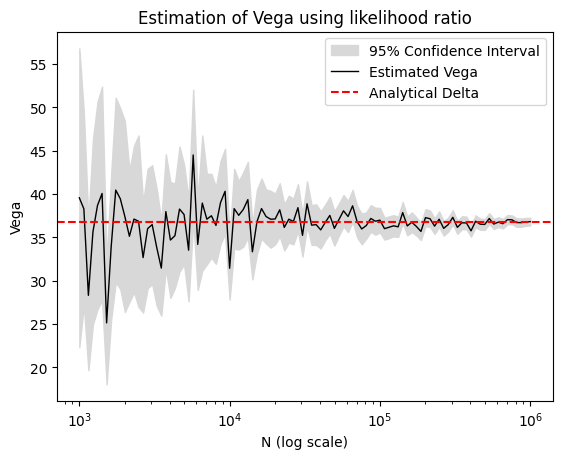

In [15]:
vegas = np.empty(num_NN, dtype=float)
vegas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)
    
    sample = f(S(WT)) * de_sig_logp(S(WT))
    
    vegas[i] = np.mean(sample)
    vegas_std[i] = np.std(sample)/np.sqrt(N)

stds["vega_lr"] = np.std(sample)


plt.fill_between(
    NN, 
    vegas - 1.96*vegas_std, 
    vegas + 1.96*vegas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    vegas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Vega'
)
plt.axhline(
    y=vega_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Vega")
plt.title("Estimation of Vega using likelihood ratio")

plt.legend()
plt.savefig(PLOTS_FOLDER + "a_vega_like_ratio.pdf", format='pdf', bbox_inches='tight')

#### Compare variances

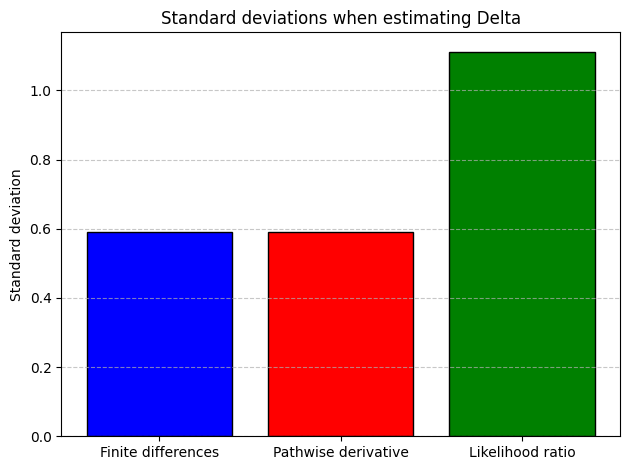

In [16]:
names = ["delta_fd", "delta_pw", "delta_lr"]
bar_names = ["Finite differences", "Pathwise derivative", "Likelihood ratio"]

std_values = np.array([stds[name] for name in names])

x_pos = np.arange(len(names))

plt.bar(x_pos, std_values, color=["blue", "red", "green"], edgecolor='black')
plt.xticks(x_pos, bar_names)
plt.ylabel('Standard deviation')
plt.title('Standard deviations when estimating Delta')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(PLOTS_FOLDER + "a_delta_vars.pdf", format='pdf', bbox_inches='tight')

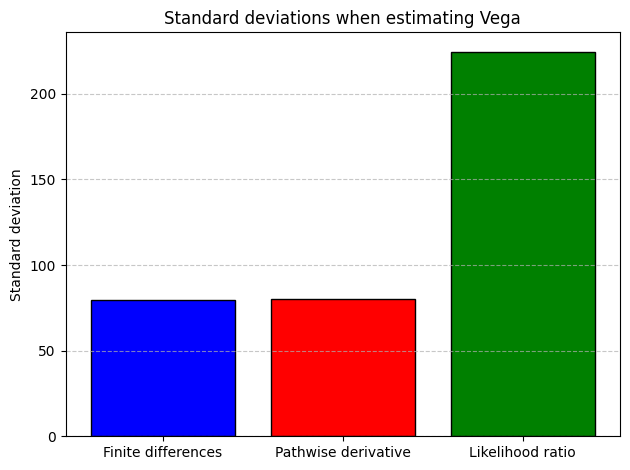

In [17]:
names = ["vega_fd", "vega_pw", "vega_lr"]
bar_names = ["Finite differences", "Pathwise derivative", "Likelihood ratio"]

std_values = np.array([stds[name] for name in names])

x_pos = np.arange(len(names))

plt.bar(x_pos, std_values, color=["blue", "red", "green"], edgecolor='black')
plt.xticks(x_pos, bar_names)
plt.ylabel('Standard deviation')
plt.title('Standard deviations when estimating Vega')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(PLOTS_FOLDER + "a_vega_vars.pdf", format='pdf', bbox_inches='tight')

### b) Estimate Gamma

#### Estimate Gamma using pathwise derivative twice

In [18]:
# Define second derivative of f and second derivative of S wrt S0
def de2_f(S, r = 0.05, T = 1, K = 120):
    return np.array([0. for x in S])
def de2_S0_S(WT, r = 0.05, T = 1, sig = 0.25, S0=100):
    return np.array([0. for x in WT])

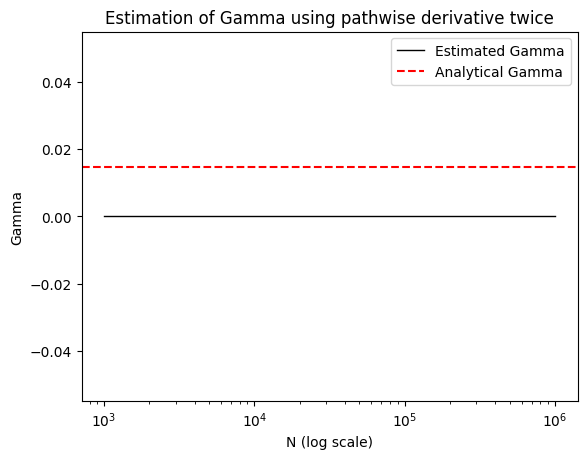

In [19]:
gammas = np.empty(num_NN, dtype=float)
gammas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)
    
    sample = de2_f(S(WT)) * de_S0_S(WT) + de_f(S(WT)) * de2_S0_S(WT)
    
    gammas[i] = np.mean(sample)
    gammas_std[i] = np.std(sample)/np.sqrt(N)

stds["gamma_pw_pw"] = np.std(sample)


plt.plot(
    NN, 
    gammas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Gamma'
)
plt.axhline(
    y=gamma_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Gamma'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Gamma")
plt.title("Estimation of Gamma using pathwise derivative twice")

plt.legend()
plt.savefig(PLOTS_FOLDER + "b_pw_pw.pdf", format='pdf', bbox_inches='tight')

#### Estimate Gamma using likelihood ratio twice

In [20]:
# Define second derivative of the score function wrt sigma
def de2_S0_logp(S, r = 0.05, T = 1, sig = 0.25, S0=100):
    return (- np.log(S/S0) + (r-0.5*sig**2)*T - 1.)/(sig**2*T*S0**2)

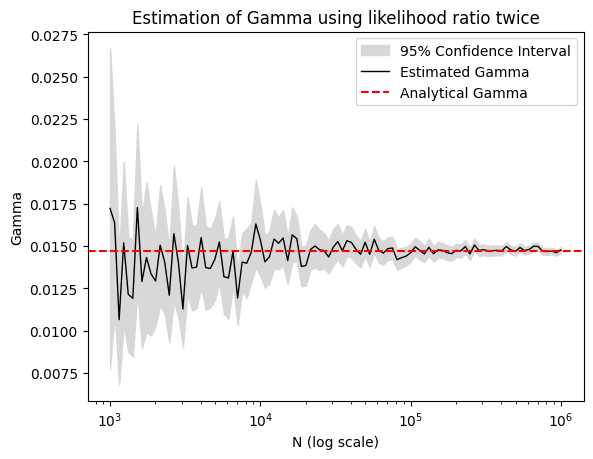

In [21]:
gammas = np.empty(num_NN, dtype=float)
gammas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = f(S(WT)) * (de2_S0_logp(S(WT)) + de_S0_logp(S(WT))**2)
    
    gammas[i] = np.mean(sample)
    gammas_std[i] = np.std(sample)/np.sqrt(N)

stds["gamma_lr_lr"] = np.std(sample)


plt.fill_between(
    NN, 
    gammas - 1.96*gammas_std, 
    gammas + 1.96*gammas_std,
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    gammas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Gamma'
)
plt.axhline(
    y=gamma_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Gamma'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Gamma")
plt.title("Estimation of Gamma using likelihood ratio twice")

plt.legend()
plt.savefig(PLOTS_FOLDER + "b_lr_lr.pdf", format='pdf', bbox_inches='tight')

#### Estimate Gamma using pathwise derivative first and likelihood ratio second

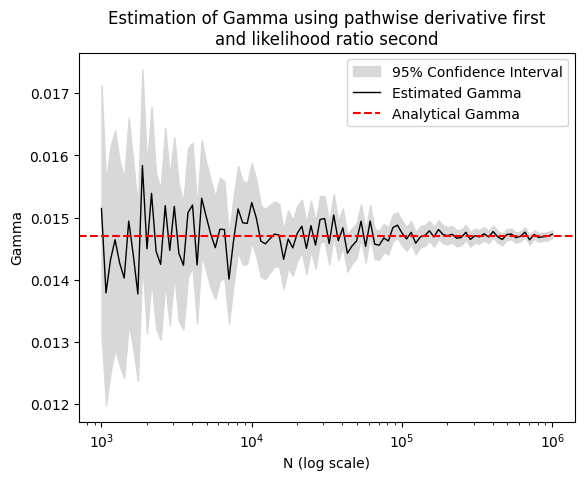

In [22]:
gammas = np.empty(num_NN, dtype=float)
gammas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = - de_f(S(WT)) * S(WT) / S0**2 + de_f(S(WT)) * S(WT) * de_S0_logp(S(WT)) / S0
    
    gammas[i] = np.mean(sample)
    gammas_std[i] = np.std(sample)/np.sqrt(N)

stds["gamma_pw_lr"] = np.std(sample)


plt.fill_between(
    NN, 
    gammas - 1.96*gammas_std, 
    gammas + 1.96*gammas_std,
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    gammas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Gamma'
)
plt.axhline(
    y=gamma_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Gamma'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Gamma")
plt.title("Estimation of Gamma using pathwise derivative first\nand likelihood ratio second")

plt.legend()
plt.savefig(PLOTS_FOLDER + "b_pw_lr.pdf", format='pdf', bbox_inches='tight')

#### Estimate Gamma using likelihood ratio first and pathwise derivative second

In [23]:
# Define mixed derivative of the score function wrt S0 and S
def de_S_de_S0_logp(S, r = 0.05, T = 1, sig = 0.25, S0=100):
    return 1./(sig**2 * T * S0 * S)

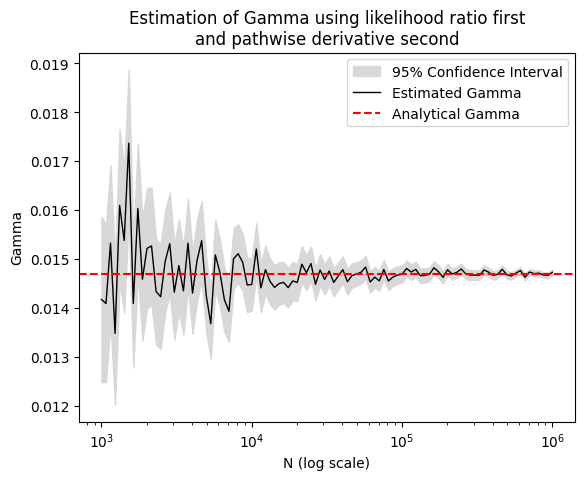

In [24]:
gammas = np.empty(num_NN, dtype=float)
gammas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    WT = rng.normal(0, T, size=N)

    sample = (de_f(S(WT))*de_S0_logp(S(WT)) + f(S(WT))*de_S_de_S0_logp(S(WT))) * de_S0_S(WT) + f(S(WT))*de2_S0_logp(S(WT))
    
    gammas[i] = np.mean(sample)
    gammas_std[i] = np.std(sample)/np.sqrt(N)

stds["gamma_lr_pw"] = np.std(sample)


plt.fill_between(
    NN, 
    gammas - 1.96*gammas_std, 
    gammas + 1.96*gammas_std, 
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    gammas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Gamma'
)
plt.axhline(
    y=gamma_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Gamma'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Gamma")
plt.title("Estimation of Gamma using likelihood ratio first\nand pathwise derivative second")

plt.legend()
plt.savefig(PLOTS_FOLDER + "b_lr_pw.pdf", format='pdf', bbox_inches='tight')

#### Compare variances

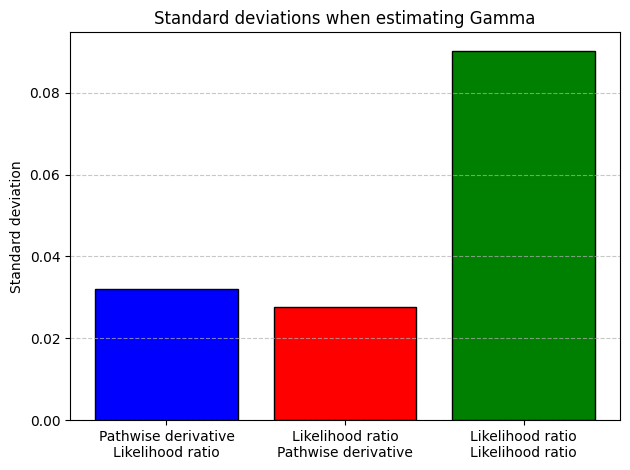

In [25]:
names = ["gamma_pw_lr", "gamma_lr_pw", "gamma_lr_lr"]
bar_names = ["Pathwise derivative\nLikelihood ratio", "Likelihood ratio\nPathwise derivative", "Likelihood ratio\nLikelihood ratio"]

std_values = np.array([stds[name] for name in names])

x_pos = np.arange(len(names))

plt.bar(x_pos, std_values, color=["blue", "red", "green"], edgecolor='black')
plt.xticks(x_pos, bar_names)
plt.ylabel('Standard deviation')
plt.title('Standard deviations when estimating Gamma')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(PLOTS_FOLDER + "b_gamma_vars.pdf", format='pdf', bbox_inches='tight')

## Digital call option
The payoff of a Digital call option at maturity is defined as
$$f(S_T) = e^{-rT}\mathbf{I}\{S_T>K\}.$$
Here we take
- interest rate $r = 0.05$
- maturity time $T = 0.25$
- volatility $\sigma = 0.25$
- initial asset price $S_0 = 100$
- strike price $K = 100$

In [26]:
# Define S and f for Digital call option
def S(WT, r = 0.05, T = 0.25, sig = 0.25, S0=100):
    return S0 * np.exp((r-0.5*sig**2)*T + sig*WT)
def f(S, r = 0.05, T = 0.25, K = 100):
    return np.exp(-r*T) * np.array([1. if x > K else 0. for x in S])

# Approximate f as fe + he
def fe(S, r = 0.05, T = 0.25, K = 100, eps=20):
    if eps == 0:
        return f(S, r=r, T=T, K=K)
    else:
        return np.exp(-r*T) * np.clip((S-K+eps)/(2*eps), 0, 1)
def he(S, r = 0.05, T = 0.25, K = 100, eps=20):
    return f(S, r=r, T=T, K=K) - fe(S, r=r, T=T, K=K, eps=eps)

# Define derivarive of fe, derivative of S wrt S0, and derivative of the score function wrt S0
def de_fe(S, r = 0.05, T = 0.25, K = 100, eps=20):
    return np.exp(-r*T) * np.array([1./(2*eps) if -eps < x-K <= eps else 0. for x in S])
def de_S0_S(WT, r = 0.05, T = 0.25, sig = 0.25, S0=100):
    return np.exp((r-0.5*sig**2)*T + sig*WT)
def de_S0_logp(S, r = 0.05, T = 0.25, sig = 0.25, S0=100):
    return (np.log(S/S0)-(r-0.5*sig**2)*T)/(sig**2*T*S0)

# Define function for analytical value
def delta_analytical(S0, K, r=0.05, T=0.25, sig=0.25):
    s1 = norm.pdf((np.log(K/S0) - (r - 0.5 * sig**2)*T) / (sig * np.sqrt(T)))
    return np.exp(- r * T) * s1 / (S0 * sig * np.sqrt(T))

# Set parameters
r = 0.05
T = 0.25
sig = 0.25
S0 = 100
K = 100

num_NN = 100
NN = np.logspace(3,6,num_NN).astype(int)
NN = np.array([x for (i,x) in enumerate(NN) if i==0 or x>NN[i-1]])

eps = 20

In [27]:
# Use a pilot run to determine the optimal split ratio
N = 10000000

WT1 = rng.normal(0, T, size=N)
WT2 = rng.normal(0, T, size=N)

sample1 = de_fe(S(WT1)) * de_S0_S(WT1)
sample2 = he(S(WT2)) * de_S0_logp(S(WT2))

var1 = np.var(sample1)
var2 = np.var(sample2)

alpha = var1/(var1+var2)

print(f"Optimal split ratio: {100*alpha:.2f}%")

Optimal split ratio: 13.37%


#### c) Estimate Delta

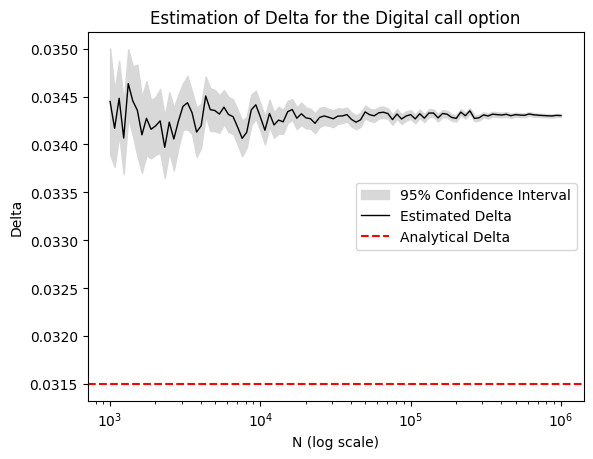

In [28]:
deltas = np.empty(num_NN, dtype=float)
deltas_std = np.empty(num_NN, dtype=float)
for i, N in enumerate(NN):
    N1 = int(N*alpha)
    N2 = N - N1

    WT1 = rng.normal(0, T, size=N1)
    WT2 = rng.normal(0, T, size=N2)

    sample1 = de_fe(S(WT1)) * de_S0_S(WT1)
    sample2 = he(S(WT2)) * de_S0_logp(S(WT2))
    
    deltas[i] = np.mean(sample1) + np.mean(sample2)
    deltas_std[i] = np.sqrt(np.var(sample1)/N1 + np.var(sample2)/N2)


plt.fill_between(
    NN, 
    deltas - 1.96*deltas_std, 
    deltas + 1.96*deltas_std,
    label='95% Confidence Interval',
    color='#D8D8D8',
    edgecolor='#D8D8D8'
)
plt.plot(
    NN, 
    deltas, 
    linestyle='-',
    color='black',
    linewidth=1,
    label='Estimated Delta'
)
plt.axhline(
    y=delta_analytical(S0, K, r, sig, T), 
    color='red', 
    linestyle='--', 
    linewidth=1.5, 
    label='Analytical Delta'
)

plt.xscale('log')

plt.xlabel("N (log scale)")
plt.ylabel("Delta")
plt.title("Estimation of Delta for the Digital call option")

plt.legend(loc='center right')
plt.savefig(PLOTS_FOLDER + "c_delta.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [29]:
print(f"The relative error is {(deltas[-1]/delta_analytical(S0, K, r, sig, T) - 1)*100:.03f}%")

The relative error is 8.905%


#### d) Investigate how Epsilon impacts the variance of the estimator

In [30]:
# Set parameters
N = 1000000

eeps_num = 1000
eeps = np.linspace(0,80,eeps_num)

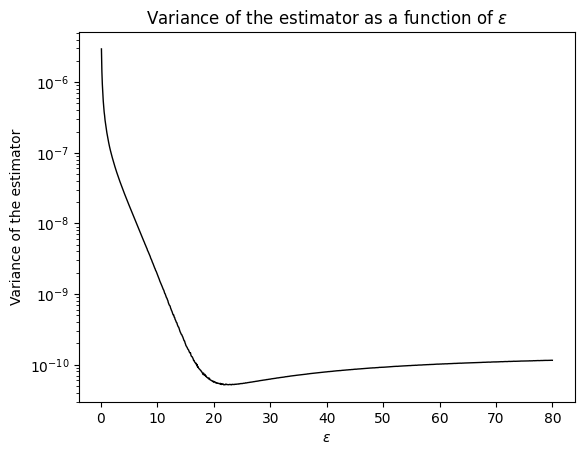

In [31]:
deltas = np.empty(eeps_num, dtype=float)
deltas_var = np.empty(eeps_num, dtype=float)
for i, eps in enumerate(eeps):
    N1 = int(N*alpha)
    N2 = N - N1

    WT1 = rng.normal(0, T, size=N1)
    WT2 = rng.normal(0, T, size=N2)

    sample1 = de_fe(S(WT1), eps=eps) * de_S0_S(WT1)
    sample2 = he(S(WT2), eps=eps) * de_S0_logp(S(WT2))
    
    deltas[i] = np.mean(sample1) + np.mean(sample2)
    deltas_var[i] = np.var(sample1)/N1 + np.var(sample2)/N2


plt.plot(
    eeps[1:], 
    deltas_var[1:], 
    linestyle='-',
    color='black',
    linewidth=1,
    label=''
)

plt.yscale('log')

plt.xlabel(r"$\epsilon$")
plt.ylabel("Variance of the estimator")
plt.title(r"Variance of the estimator as a function of $\epsilon$")

plt.savefig(PLOTS_FOLDER + "d_delta_eps.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [32]:
eps_opt = eeps[np.argmin(deltas_var[1:])]
print(f"The minimal variance is achieved when eps = {eps_opt:.02f}")

The minimal variance is achieved when eps = 21.70
